# Практическая работа №2
## Бакин Д.И. ББМО-01-23
## Windows


### Подключение библиотек



In [3]:
# Библиотека для использования регулярных выражений
import re
# Библиотека для работы с классом времени
from datetime import datetime
# Библиотека для использования базы данных SQLite
import sqlite3
# Библиотека для удобной работы с табличными данными
import pandas as pd
# Библиотека для удобной визуализации данных
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dts

### Установка и открытие лог-файла


In [4]:
# Скопируем репозиторий с github
!git clone https://github.com/logpai/loghub.git

Cloning into 'loghub'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 575 (delta 146), reused 136 (delta 133), pack-reused 401 (from 1)
Receiving objects: 100% (575/575), 7.27 MiB | 14.24 MiB/s, done.
Resolving deltas: 100% (267/267), done.


In [5]:
# Откроем файл и выведем его содержимое (Первые 10 строк)
windows_logs = open('/content/loghub/Windows/Windows_2k.log', 'r').readlines()
for log in windows_logs[:10]:
  print(log.replace('\n', ''))

2016-09-28 04:30:30, Info                  CBS    Loaded Servicing Stack v6.1.7601.23505 with Core: C:\Windows\winsxs\amd64_microsoft-windows-servicingstack_31bf3856ad364e35_6.1.7601.23505_none_681aa442f6fed7f0\cbscore.dll
2016-09-28 04:30:31, Info                  CSI    00000001@2016/9/27:20:30:31.455 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fef9fb9b6d @0x7fef9f8358f @0xff83e97c @0xff83d799 @0xff83db2f)
2016-09-28 04:30:31, Info                  CSI    00000002@2016/9/27:20:30:31.458 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fefa006ade @0x7fef9fd2984 @0x7fef9f83665 @0xff83e97c @0xff83d799)
2016-09-28 04:30:31, Info                  CSI    00000003@2016/9/27:20:30:31.458 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fefa1c8728 @0x7fefa1c8856 @0xff83e474 @0xff83d7de @0xff83db2f)
2016-09-28 04:30:31, Info                  CBS    Ending TrustedInstaller initialization.
2016-09-28 04:30:31, Info     

Отдельная запись выглядит следующим образом:

In [6]:
# 2016-09-28 04:30:30, Info                  CBS    Loaded Servicing Stack v6.1.7601.23505 with Core: C:\Windows\winsxs\amd64_microsoft-windows-servicingstack_31bf3856ad364e35_6.1.7601.23505_none_681aa442f6fed7f0\cbscore.dll

Структура следующая:
* **Дата в формате ГОД-МЕСЯЦ-ДЕНЬ ЧАС:МИНУТА:СЕКУНДА** (в данном случае 28 сентября 2016, в 04:30:30)
* **Уровень логирования** (в данном случае INFO)
* **CBS или CSI** (в данном случае CBS)
* **Описание действия** (в данном случае Loaded Servicing Stack v6.1.7601.23505 with Core: C:\Windows\winsxs\amd64_microsoft-windows-servicingstack_31bf3856ad364e35_6.1.7601.23505_none_681aa442f6fed7f0\cbscore.dll)

### Парсинг лог-файла

In [7]:
# pattern = r'\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}'
windows_logs_normalized = []
for log in windows_logs:
  # date = datetime.strptime(log[0:19], '%Y-%m-%d %H:%M:%S')
  date = log[0:19]
  level = log[21:25]
  component = log[43:46]
  content = log[50:].replace('"', '').replace('\n', '')
  windows_logs_normalized.append([date, level, component, content])

for _ in windows_logs_normalized[:10]:
  print(_)

['2016-09-28 04:30:30', 'Info', 'CBS', 'Loaded Servicing Stack v6.1.7601.23505 with Core: C:\\Windows\\winsxs\\amd64_microsoft-windows-servicingstack_31bf3856ad364e35_6.1.7601.23505_none_681aa442f6fed7f0\\cbscore.dll']
['2016-09-28 04:30:31', 'Info', 'CSI', '00000001@2016/9/27:20:30:31.455 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fef9fb9b6d @0x7fef9f8358f @0xff83e97c @0xff83d799 @0xff83db2f)']
['2016-09-28 04:30:31', 'Info', 'CSI', '00000002@2016/9/27:20:30:31.458 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fefa006ade @0x7fef9fd2984 @0x7fef9f83665 @0xff83e97c @0xff83d799)']
['2016-09-28 04:30:31', 'Info', 'CSI', '00000003@2016/9/27:20:30:31.458 WcpInitialize (wcp.dll version 0.0.0.6) called (stack @0x7fed806eb5d @0x7fefa1c8728 @0x7fefa1c8856 @0xff83e474 @0xff83d7de @0xff83db2f)']
['2016-09-28 04:30:31', 'Info', 'CBS', 'Ending TrustedInstaller initialization.']
['2016-09-28 04:30:31', 'Info', 'CBS', 'Starting the TrustedInstal

### Сохранение каждой записи в СУБД

In [8]:
# Создание СУБД
connection = sqlite3.connect('logs.db')
cursor = connection.cursor()
cursor.execute("DROP TABLE IF EXISTS logs")
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, datetime text, level text, component text, content text)")

# Внесение данных в СУБД
for _ in windows_logs_normalized:
  query = f'INSERT INTO logs (datetime, level, component, content) VALUES ("{_[0]}", "{_[1]}", "{_[2]}", "{_[3]}")'
  try:
    cursor.execute(query)
  except:
    print(query)

# Закрытие СУБД
connection.commit()
cursor.close()
connection.close()

# Открытие СУБД
connection = sqlite3.connect('logs.db')
cursor = connection.cursor()
cursor.execute("SELECT * FROM logs")
data = cursor.fetchall()
cursor.close()
connection.close()
pd_data = pd.DataFrame(data, columns=("i", "Время", "Уровень", "Компонент", "Содержание"))
pd_data

,i,Время,Уровень,Компонент,Содержание
0,1,2016-09-28 04:30:30,Info,CBS,Loaded Servicing Stack v6.1.7601.23505 with Co...
1,2,2016-09-28 04:30:31,Info,CSI,00000001@2016/9/27:20:30:31.455 WcpInitialize ...
2,3,2016-09-28 04:30:31,Info,CSI,00000002@2016/9/27:20:30:31.458 WcpInitialize ...
3,4,2016-09-28 04:30:31,Info,CSI,00000003@2016/9/27:20:30:31.458 WcpInitialize ...
4,5,2016-09-28 04:30:31,Info,CBS,Ending TrustedInstaller initialization.
...,...,...,...,...,...
1995,1996,2016-09-29 02:04:40,Info,CBS,Read out cached package applicability for pack...
1996,1997,2016-09-29 02:04:40,Info,CBS,Session: 30546354_3360174372 initialized by cl...
1997,1998,2016-09-29 02:04:40,Info,CBS,Read out cached package applicability for pack...
1998,1999,2016-09-29 02:04:40,Info,CBS,Session: 30546354_3363894584 initialized by cl...


### Визуализация результатов

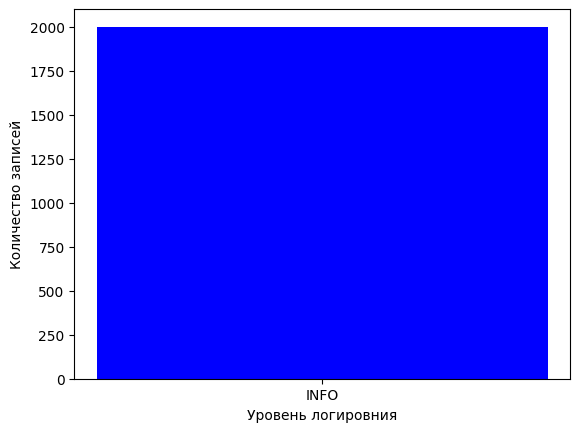

In [9]:
# Подсчёт записей с различными уровнями логирования
pd_data_distrib = pd_data['Уровень'].value_counts()

x = pd_data_distrib.keys()
y = pd_data_distrib.values

# Заголовки для графика
verbose_xticks = ["INFO", "WARN"]

plt.xticks([0,1], verbose_xticks)
plt.xlabel('Уровень логировния')
plt.ylabel('Количество записей')
plt.bar(x,y)
plt.bar(x,y, color = ['blue', 'red'])

plt.show()

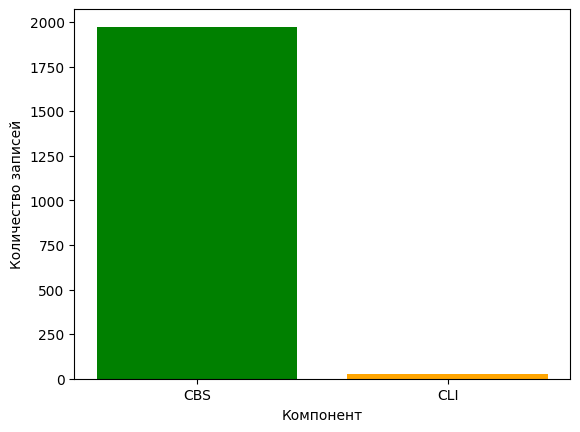

In [10]:
# Подсчёт логирующих компонентов
pd_data_distrib = pd_data['Компонент'].value_counts()

x = pd_data_distrib.keys()
y = pd_data_distrib.values

# Заголовки для графика
verbose_xticks = ["CBS", "CLI"]

plt.xticks([0,1], verbose_xticks)
plt.xticks(rotation=0)
plt.xlabel('Компонент')
plt.ylabel('Количество записей')
plt.bar(x,y)
plt.bar(x,y, color = ['green', 'orange'])

plt.show()

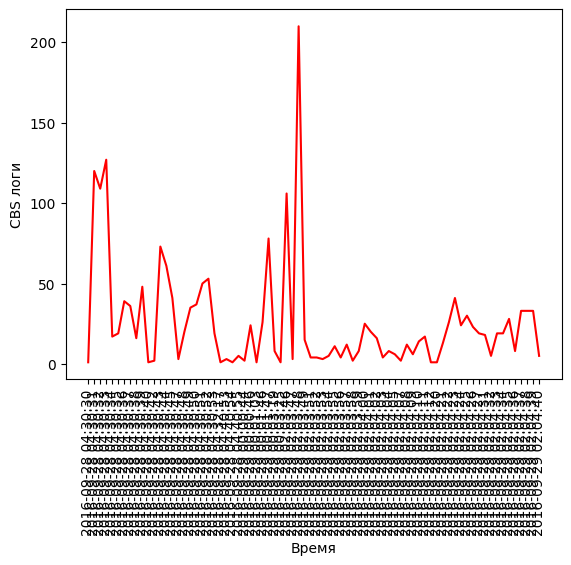

In [11]:
# Когда логировались записи в CBS
# Частота появления CBS логов
cbs_df = pd_data[pd_data['Компонент'] == 'CBS'].copy()
cbs_df['Компонент'] = pd.to_datetime(cbs_df['Время'])
cbs_count = cbs_df.groupby('Время').size()

plt.plot(cbs_count.index, cbs_count.values, linestyle='-', color='r')
plt.xlabel('Время')
plt.xticks(rotation=90)
plt.ylabel('CBS логи')

plt.show()

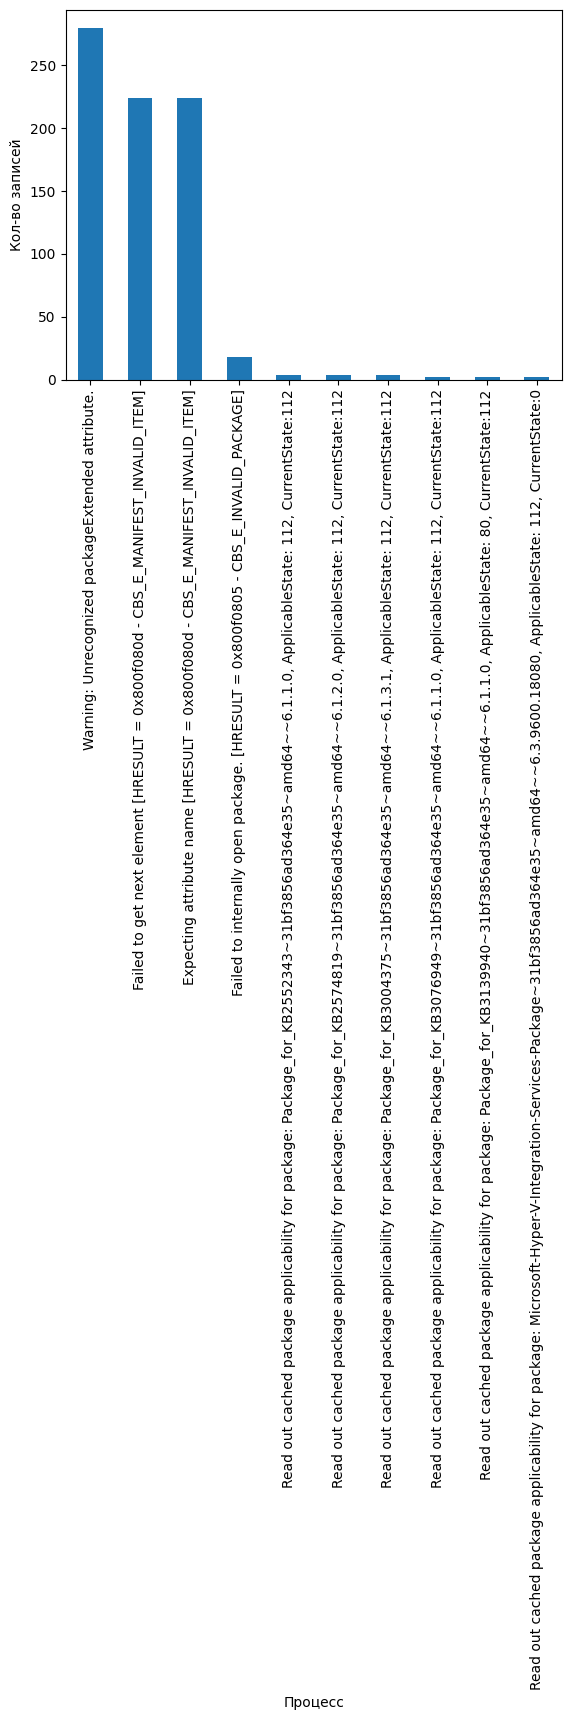

In [12]:
# Подсчёт наиболее частых сообщений в файле с логами
pd_data_distrib = pd_data['Содержание'].value_counts()[:10]
pd_data_distrib.plot(kind='bar')

plt.xlabel('Процесс')
plt.ylabel('Кол-во записей')
plt.show()